In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
#from skimage import io, transform
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [2]:
def show_image_batch(img_list, title=None):
    num = len(img_list)
    fig = plt.figure()
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        ax.imshow(img_list[i].numpy().transpose([1,2,0]))
        ax.set_title(title[i])

    plt.show()

In [3]:
# batch size
bs = 32
# size of ech side of the images
size = 128

In [4]:
# Load Data
dataset = datasets.ImageFolder(root='/home/martin/Dropbox/doctorado/chapter00_courses/procesamiento_digital_imagenes/final_project/pytorch/data/brain_tumor/brain_images/training_set', transform=transforms.Compose([
    transforms.Resize(size=(size,size)),
    transforms.Scale(size),
    transforms.RandomCrop(size),
    transforms.Grayscale(1),
    transforms.ToTensor()
]))    

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset = train_dataset, batch_size=bs, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_dataset, batch_size=bs, shuffle=False, num_workers=0)

/home/martin/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


# Generate Noisy samples

In [10]:
# level of noise to corrupt images
noise_level = 0.2

In [14]:
# visualize input images
dataiter = iter(train_loader)
im, labels = dataiter.next()
imag = im[0]

# Random Noise 
noise_random = torch.rand(bs,1,size,size)
img_noise_random = (imag.double()  + (noise_level * noise_random).double())

# Low Pass Filter
blur = cv2.GaussianBlur(imag.numpy(),(7,7),0,0.2)
img_noise_lpf = (torch.from_numpy(blur))

# LPF + random noise                           
img_noise_lpf_rn = (img_noise_lpf.double() + (noise_level * noise_random).double())

# Size of the data

In [15]:
print("Len of the training set " + str(len(train_loader.dataset)))
print("Size of a raw image "+ str(imag.shape))
print("Size of a random noise picture " + str(img_noise_random[0].shape))
print("Size of a LPF picture " + str(img_noise_lpf.shape))
print("Size of a LPF+Noise picture " + str(img_noise_lpf_rn[0].shape))

Len of the training set 180
Size of a raw image torch.Size([1, 128, 128])
Size of a random noise picture torch.Size([1, 128, 128])
Size of a LPF picture torch.Size([1, 128, 128])
Size of a LPF+Noise picture torch.Size([1, 128, 128])


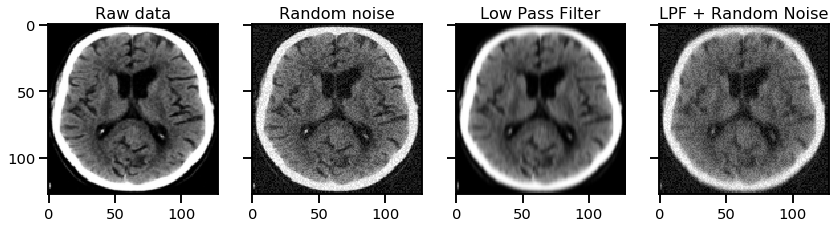

In [16]:
%matplotlib inline
# get one image from the batch
sns.set_context("talk", font_scale=0.9)
f, axarr = plt.subplots(1,4,sharex=True, sharey=True)
f.set_size_inches(14, 12)
axarr[0].imshow(np.squeeze(imag), cmap='gray')
axarr[0].set_title('Raw data')
axarr[1].imshow(np.squeeze(img_noise_random[0]), cmap='gray')
axarr[1].set_title('Random noise')
axarr[2].imshow( np.squeeze(img_noise_lpf), cmap='gray')
axarr[2].set_title('Low Pass Filter')
axarr[3].imshow( np.squeeze(img_noise_lpf_rn[0]), cmap='gray')
axarr[3].set_title('LPF + Random Noise')
plt.show()

In [102]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x



# Training with Raw data

In [103]:
# number of epochs to train the model
n_epochs = 50
lrate = 0.007

In [104]:
# initialize the NN
model = ConvAutoencoder()
print(model)

# specify loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [105]:
# Define the type of noise
noise_type = 'raw'

In [106]:
loss_vector = np.zeros(n_epochs)
loss_vector_te = np.zeros(n_epochs)
for epoch in range(0, n_epochs):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ########## TRAIN ###########
        ########## TRAIN ###########
            ########## TRAIN ###########
    
    for brains in train_loader:
        data, _ = brains
        
        if (noise_type == 'raw'):
                data_batch = data

        elif (noise_type == 'random'):
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(data  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data_batch)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        
    ########## TEST ###########
        ########## TEST ###########
            ########## TEST ###########
        
    for brains_te in test_loader:
        data_te, _ = brains_te
        
        if (noise_type == 'raw'):
                data_batch = data_te

        elif (noise_type == 'random'):
                noise_random = torch.rand(data_te.shape[0],1,size,size)
                data_batch = Variable(data_te  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data_te[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_te = model(data_batch)
        # calculate the loss
        loss_te = criterion(outputs_te, data_te)
        # update running training loss
        test_loss += loss_te.item()*data_te.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_vector[epoch] = train_loss
    test_loss = test_loss/len(test_loader)
    loss_vector_te[epoch] = test_loss
    print('Epoch: {} \tTrain Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, 
        test_loss
        ))

Epoch: 0 	Train Loss: 2.705806
Epoch: 0 	Test Loss: 1.731257
Epoch: 1 	Train Loss: 2.348247
Epoch: 1 	Test Loss: 1.374104
Epoch: 2 	Train Loss: 1.678094
Epoch: 2 	Test Loss: 0.871713
Epoch: 3 	Train Loss: 0.962490
Epoch: 3 	Test Loss: 0.522935
Epoch: 4 	Train Loss: 0.696252
Epoch: 4 	Test Loss: 0.444954
Epoch: 5 	Train Loss: 0.617293
Epoch: 5 	Test Loss: 0.392570
Epoch: 6 	Train Loss: 0.540401
Epoch: 6 	Test Loss: 0.334634
Epoch: 7 	Train Loss: 0.466225
Epoch: 7 	Test Loss: 0.302159
Epoch: 8 	Train Loss: 0.419892
Epoch: 8 	Test Loss: 0.273280
Epoch: 9 	Train Loss: 0.382516
Epoch: 9 	Test Loss: 0.251199
Epoch: 10 	Train Loss: 0.353610
Epoch: 10 	Test Loss: 0.231906
Epoch: 11 	Train Loss: 0.328505
Epoch: 11 	Test Loss: 0.218787
Epoch: 12 	Train Loss: 0.314581
Epoch: 12 	Test Loss: 0.214084
Epoch: 13 	Train Loss: 0.306197
Epoch: 13 	Test Loss: 0.207476
Epoch: 14 	Train Loss: 0.296991
Epoch: 14 	Test Loss: 0.200194
Epoch: 15 	Train Loss: 0.288874
Epoch: 15 	Test Loss: 0.196843
Epoch: 16 	T

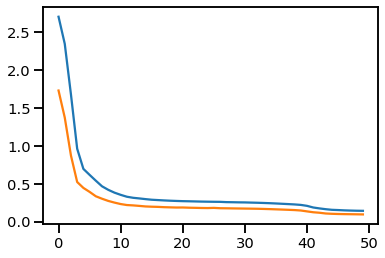

In [107]:
plt.plot(loss_vector)
plt.plot(loss_vector_te)
plt.show()

In [108]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

# get sample outputs
output_raw = model(images_raw)
# prep images for display
images_raw = images_raw.detach().numpy()

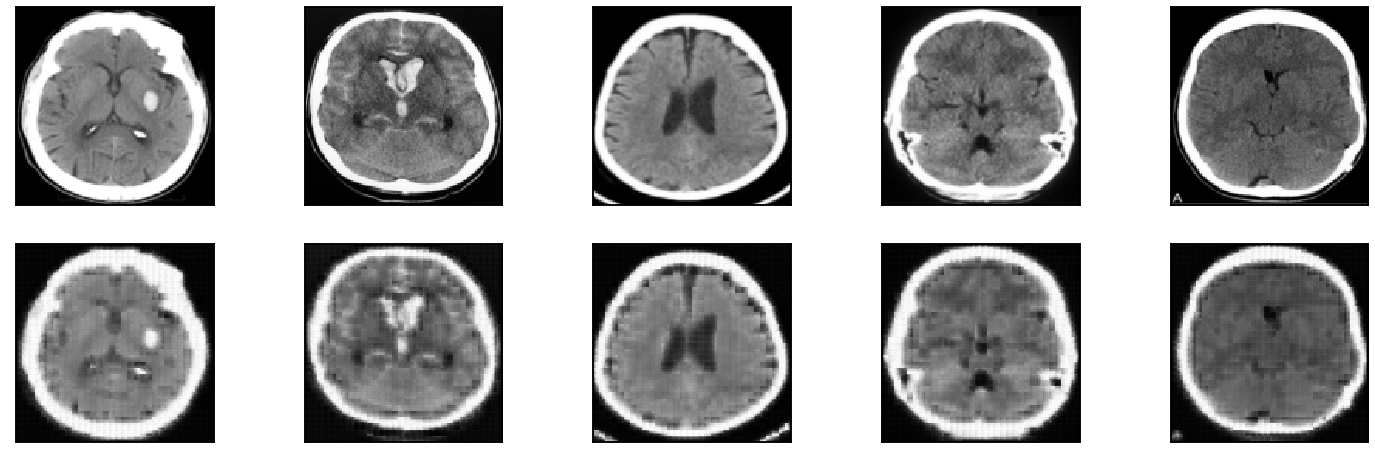

In [109]:
output_raw_im = output_raw
output_raw_im = output_raw_im.detach().numpy()

# plot the first 5 input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,8))

# input images on top row, reconstructions on bottom
for images, row in zip([images_raw, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Train with Random Noise

In [122]:
# number of epochs to train the model
n_epochs = 50
lrate = 0.007
noise_level = 0.6

In [123]:
# initialize the NN
model = ConvAutoencoder()
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [124]:
noise_type = 'random'

In [125]:
loss_vector = np.zeros(n_epochs)
loss_vector_te = np.zeros(n_epochs)
for epoch in range(0, n_epochs):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ########## TRAIN ###########
        ########## TRAIN ###########
            ########## TRAIN ###########
    
    for brains in train_loader:
        data, _ = brains
        
        if (noise_type == 'raw'):
                data_batch = data

        elif (noise_type == 'random'):
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(data  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data_batch)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        
    ########## TEST ###########
        ########## TEST ###########
            ########## TEST ###########
        
    for brains_te in test_loader:
        data_te, _ = brains_te
        
        if (noise_type == 'raw'):
                data_batch = data_te

        elif (noise_type == 'random'):
                noise_random = torch.rand(data_te.shape[0],1,size,size)
                data_batch = Variable(data_te  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data_te[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_te = model(data_batch)
        # calculate the loss
        loss_te = criterion(outputs_te, data_te)
        # update running training loss
        test_loss += loss_te.item()*data_te.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_vector[epoch] = train_loss
    test_loss = test_loss/len(test_loader)
    loss_vector_te[epoch] = test_loss
    print('Epoch: {} \tTrain Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, 
        test_loss
        ))

Epoch: 0 	Train Loss: 2.762715
Epoch: 0 	Test Loss: 1.844876
Epoch: 1 	Train Loss: 2.702843
Epoch: 1 	Test Loss: 1.799225
Epoch: 2 	Train Loss: 2.537355
Epoch: 2 	Test Loss: 1.606128
Epoch: 3 	Train Loss: 2.120304
Epoch: 3 	Test Loss: 1.238839
Epoch: 4 	Train Loss: 1.506186
Epoch: 4 	Test Loss: 0.820153
Epoch: 5 	Train Loss: 0.988785
Epoch: 5 	Test Loss: 0.594680
Epoch: 6 	Train Loss: 0.776379
Epoch: 6 	Test Loss: 0.496609
Epoch: 7 	Train Loss: 0.658819
Epoch: 7 	Test Loss: 0.422640
Epoch: 8 	Train Loss: 0.578059
Epoch: 8 	Test Loss: 0.381015
Epoch: 9 	Train Loss: 0.532231
Epoch: 9 	Test Loss: 0.354252
Epoch: 10 	Train Loss: 0.502088
Epoch: 10 	Test Loss: 0.337632
Epoch: 11 	Train Loss: 0.486000
Epoch: 11 	Test Loss: 0.330782
Epoch: 12 	Train Loss: 0.473939
Epoch: 12 	Test Loss: 0.325293
Epoch: 13 	Train Loss: 0.465728
Epoch: 13 	Test Loss: 0.320121
Epoch: 14 	Train Loss: 0.460318
Epoch: 14 	Test Loss: 0.315438
Epoch: 15 	Train Loss: 0.452913
Epoch: 15 	Test Loss: 0.313560
Epoch: 16 	T

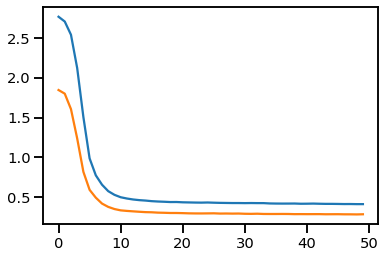

In [126]:
plt.plot(loss_vector)
plt.plot(loss_vector_te)
plt.show()

In [128]:
noise_level

0.6

In [129]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

noise_random = torch.rand(images_raw.shape[0],1,size,size)
data_batch = Variable(images_raw  + (noise_level * noise_random))


# get sample outputs
output_raw = model(data_batch)
# prep images for display
images_raw = data_batch.detach().numpy()

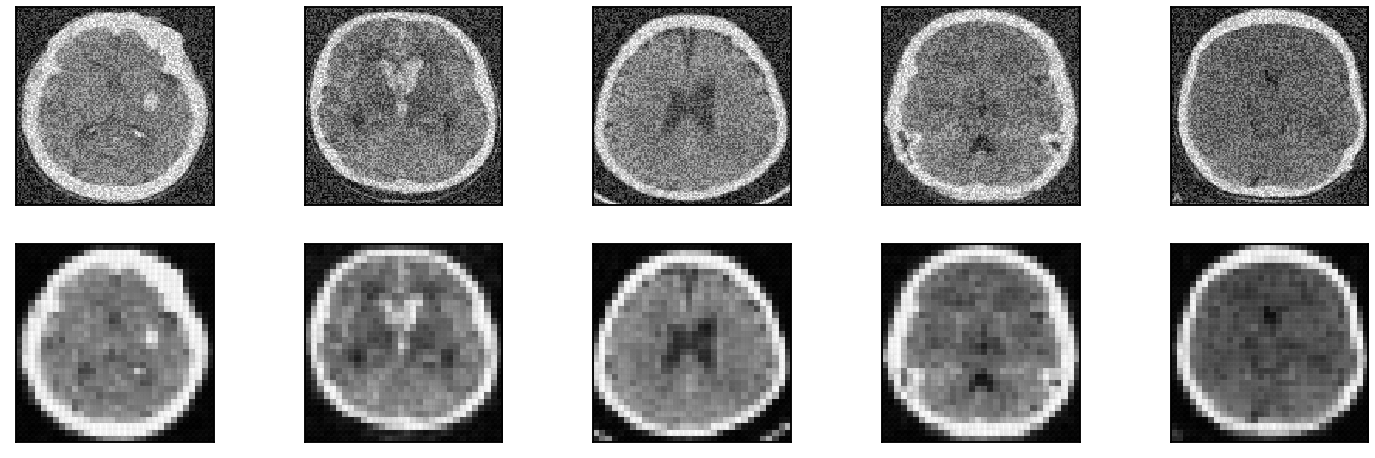

In [130]:
output_raw_im = output_raw
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,8))

# input images on top row, reconstructions on bottom
for images, row in zip([images_raw, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Train with LPF

In [131]:
# number of epochs to train the model
n_epochs = 50
lrate = 0.007
noise_level = 0.6

In [132]:
# initialize the NN
model = ConvAutoencoder()
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [133]:
noise_type = 'lpf'

In [135]:
loss_vector = np.zeros(n_epochs)
loss_vector_te = np.zeros(n_epochs)
#for epoch in range(1, n_epochs+1):
for epoch in range(0, n_epochs):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ########## TRAIN ###########
        ########## TRAIN ###########
            ########## TRAIN ###########
    
    for brains in train_loader:
        data, _ = brains
        
        if (noise_type == 'raw'):
                data_batch = data

        elif (noise_type == 'random'):
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(data  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(data.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data_batch)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        
    ########## TEST ###########
        ########## TEST ###########
            ########## TEST ###########
        
    for brains_te in test_loader:
        # _ stands in for labels, here
        # no need to flatten images
        data_te, _ = brains_te
        
        if (noise_type == 'raw'):
                data_batch = data_te

        elif (noise_type == 'random'):
                noise_random = torch.rand(data_te.shape[0],1,size,size)
                data_batch = Variable(data_te  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data_te[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_te = model(data_batch)
        # calculate the loss
        loss_te = criterion(outputs_te, data_te)
        # update running training loss
        test_loss += loss_te.item()*data_te.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_vector[epoch] = train_loss
    test_loss = test_loss/len(test_loader)
    loss_vector_te[epoch] = test_loss
    print('Epoch: {} \tTrain Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, 
        test_loss
        ))

Epoch: 0 	Train Loss: 2.431375
Epoch: 0 	Test Loss: 1.523379
Epoch: 1 	Train Loss: 2.026423
Epoch: 1 	Test Loss: 1.242954
Epoch: 2 	Train Loss: 1.595368
Epoch: 2 	Test Loss: 0.986746
Epoch: 3 	Train Loss: 1.254957
Epoch: 3 	Test Loss: 0.820414
Epoch: 4 	Train Loss: 1.053848
Epoch: 4 	Test Loss: 0.706041
Epoch: 5 	Train Loss: 0.910329
Epoch: 5 	Test Loss: 0.601807
Epoch: 6 	Train Loss: 0.786243
Epoch: 6 	Test Loss: 0.521183
Epoch: 7 	Train Loss: 0.683267
Epoch: 7 	Test Loss: 0.448192
Epoch: 8 	Train Loss: 0.586280
Epoch: 8 	Test Loss: 0.381032
Epoch: 9 	Train Loss: 0.501495
Epoch: 9 	Test Loss: 0.328738
Epoch: 10 	Train Loss: 0.438158
Epoch: 10 	Test Loss: 0.287080
Epoch: 11 	Train Loss: 0.386517
Epoch: 11 	Test Loss: 0.257905
Epoch: 12 	Train Loss: 0.354767
Epoch: 12 	Test Loss: 0.239100
Epoch: 13 	Train Loss: 0.328544
Epoch: 13 	Test Loss: 0.223874
Epoch: 14 	Train Loss: 0.307032
Epoch: 14 	Test Loss: 0.208442
Epoch: 15 	Train Loss: 0.289101
Epoch: 15 	Test Loss: 0.194310
Epoch: 16 	T

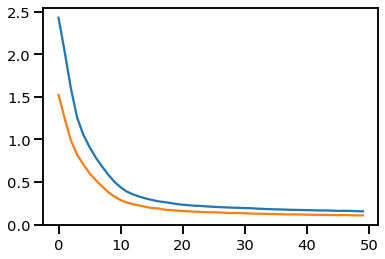

In [139]:
plt.plot(loss_vector)
plt.plot(loss_vector_te)
plt.show()

In [140]:
noise_level

0.6

In [141]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

tensor = torch.Tensor(images_raw.shape[0], 1, size, size).numpy()
for t in range(images_raw.shape[0]):
    tensor[t,:,:,:]= cv2.GaussianBlur(images_raw[t].numpy(),(7,7),0,0.2)
blur = torch.from_numpy(tensor)
data_batch = Variable(blur)

# get sample outputs
output_raw = model(data_batch)
# prep images for display
images_raw = data_batch.detach().numpy()

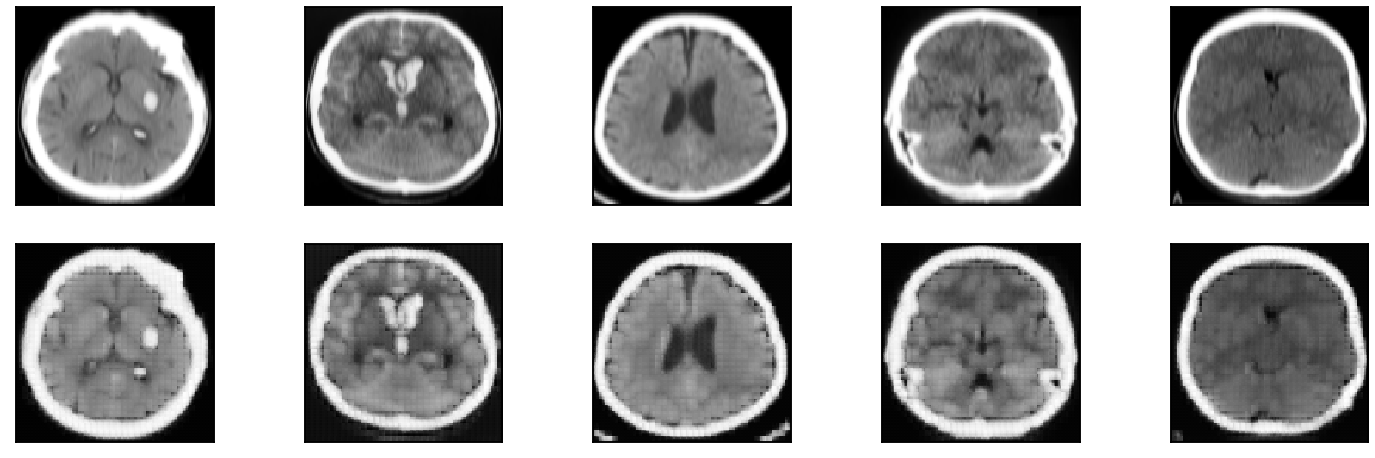

In [147]:
output_raw_im = output_raw
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,8))

# input images on top row, reconstructions on bottom
for images, row in zip([data_batch, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Training with LPF + Noise

In [160]:
# number of epochs to train the model
n_epochs = 50
lrate = 0.007
noise_level = 0.6

In [161]:
# initialize the NN
model = ConvAutoencoder()
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [155]:
noise_type = 'lpf_random'

In [162]:
loss_vector = np.zeros(n_epochs)
loss_vector_te = np.zeros(n_epochs)
#for epoch in range(1, n_epochs+1):
for epoch in range(0, n_epochs):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ########## TRAIN ###########
        ########## TRAIN ###########
            ########## TRAIN ###########
    
    for brains in train_loader:
        data, _ = brains
        
        if (noise_type == 'raw'):
                data_batch = data

        elif (noise_type == 'random'):
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(data  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(data.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(data.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur + (noise_level * noise_random))
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data_batch)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        
    ########## TEST ###########
        ########## TEST ###########
            ########## TEST ###########
        
    for brains_te in test_loader:
        data_te, _ = brains_te
        
        if (noise_type == 'raw'):
                data_batch = data_te

        elif (noise_type == 'random'):
                noise_random = torch.rand(data_te.shape[0],1,size,size)
                data_batch = Variable(data_te  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data_te[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

        elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data_te.shape[0], 1, size, size).numpy()
                for t in range(data_te.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data_te[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data_te.shape[0],1,size,size)
                data_batch = Variable(blur + (noise_level * noise_random))
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_te = model(data_batch)
        # calculate the loss
        loss_te = criterion(outputs_te, data_te)
        # update running training loss
        test_loss += loss_te.item()*data_te.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_vector[epoch] = train_loss
    test_loss = test_loss/len(test_loader)
    loss_vector_te[epoch] = test_loss
    print('Epoch: {} \tTrain Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, 
        test_loss
        ))

Epoch: 0 	Train Loss: 2.841091
Epoch: 0 	Test Loss: 1.912186
Epoch: 1 	Train Loss: 2.692651
Epoch: 1 	Test Loss: 1.788686
Epoch: 2 	Train Loss: 2.452903
Epoch: 2 	Test Loss: 1.590867
Epoch: 3 	Train Loss: 2.123567
Epoch: 3 	Test Loss: 1.380006
Epoch: 4 	Train Loss: 1.790044
Epoch: 4 	Test Loss: 1.174486
Epoch: 5 	Train Loss: 1.518182
Epoch: 5 	Test Loss: 1.021621
Epoch: 6 	Train Loss: 1.322919
Epoch: 6 	Test Loss: 0.912247
Epoch: 7 	Train Loss: 1.174717
Epoch: 7 	Test Loss: 0.810927
Epoch: 8 	Train Loss: 1.044337
Epoch: 8 	Test Loss: 0.719003
Epoch: 9 	Train Loss: 0.931754
Epoch: 9 	Test Loss: 0.639409
Epoch: 10 	Train Loss: 0.832381
Epoch: 10 	Test Loss: 0.572060
Epoch: 11 	Train Loss: 0.749857
Epoch: 11 	Test Loss: 0.518405
Epoch: 12 	Train Loss: 0.686668
Epoch: 12 	Test Loss: 0.473738
Epoch: 13 	Train Loss: 0.631712
Epoch: 13 	Test Loss: 0.434245
Epoch: 14 	Train Loss: 0.580642
Epoch: 14 	Test Loss: 0.395925
Epoch: 15 	Train Loss: 0.532783
Epoch: 15 	Test Loss: 0.364409
Epoch: 16 	T

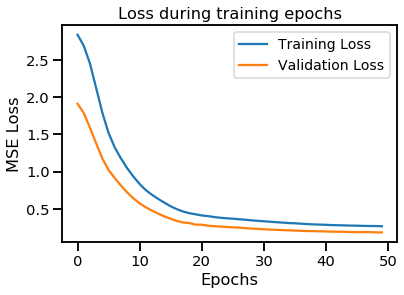

In [182]:
plt.plot(loss_vector)
plt.plot(loss_vector_te)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.title("Loss during training epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

In [164]:
noise_level

0.6

In [168]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()
raw_im = images_raw
tensor = torch.Tensor(images_raw.shape[0], 1, size, size).numpy()
for t in range(images_raw.shape[0]):
    tensor[t,:,:,:]= cv2.GaussianBlur(images_raw[t].numpy(),(7,7),0,0.2)
blur = torch.from_numpy(tensor)
noise_random = torch.rand(images_raw.shape[0],1,size,size)
data_batch = Variable(blur + (noise_level * noise_random))

# get sample outputs
output_raw = model(data_batch)
# prep images for display
images_raw = data_batch.detach().numpy()

/home/martin/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


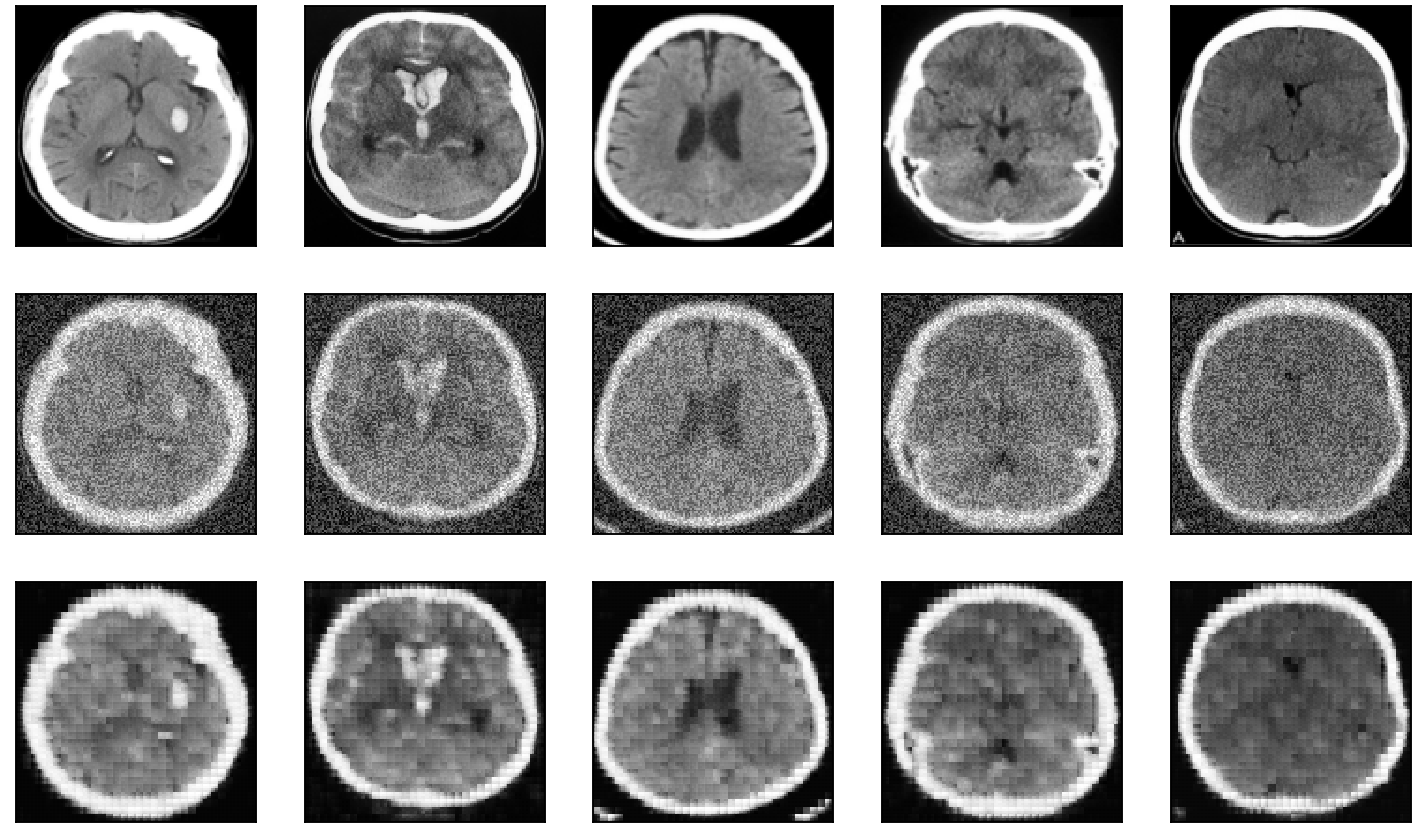

In [180]:
output_raw_im = output_raw
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(25,15))

# input images on top row, reconstructions on bottom
for images, row in zip([raw_im,data_batch, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)